# **Data Preprocessing and Exploration**

### Importing Libraries & Loading the Dataset

- We import libraries needed for data cleaning and graphs.
- pandas is used to load and work with the dataset.
- We read the Uber dataset using pd.read_csv().
- df.head() shows the first few records to understand the structure.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

df = pd.read_csv("uber.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


### Basic Exploration
- df.shape tells the number of rows and columns.
- df.info() shows data types and missing values.
- df.describe() gives numerical summary (mean, min, max, std).
- This helps us understand the dataset and plan preprocessing steps.


In [ ]:
df.shape

(200000, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [ ]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


### Handle missing data and Remove irrelevant columns

- The dataset contains some columns that do not impact price prediction.
- We drop those unnecessary columns.
- Missing values are very few, so we safely drop them.
- Clean data improves model accuracy.

In [ ]:
# Remove unnecessary columns
df = df.drop(columns=["Unnamed: 0", "key"])

In [ ]:
# Check for missing values
df.isnull().sum()

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [ ]:
# Drop rows with missing values
df = df.dropna()

### Feature engineering

- We convert datetime text into real datetime format.
- We extract useful time features (hour, weekday, month, etc.).
- Created a time_of_day feature to capture behaviour changes in fare:
- Night rides cost more
- Peak hours cost more
- These features improve model learning.

In [ ]:
# Convert to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

In [ ]:
# Drop rows where datetime could not be parsed
df = df.dropna(subset=['pickup_datetime'])

In [ ]:
# Create new features
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday

In [ ]:
# Create time_of_day column
def time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

df['time_of_day'] = df['hour'].apply(time_of_day)

# Calculate Distance Between Pickup & Dropoff

- Uber fare directly depends on distance.
- Dataset does NOT contain distance, so we compute it using Haversine Formula.
- This becomes the most important feature for fare prediction.

In [ ]:
# Haversine formula to calculate distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

df['distance_km'] = haversine_distance(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)

### Remove Outliers

- Negative/very high fares are incorrect → remove them.
- Distance above 50 km is unrealistic for NYC Uber rides.
- Passenger count must be between 1–6.
- Removing outliers prevents the model from getting confused.

In [ ]:
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 200)]
df = df[(df['distance_km'] > 0) & (df['distance_km'] < 50)]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

In [ ]:
df.shape

(193163, 14)

# Correlation Analysis

- We select only numeric features for correlation.
- Heatmap shows how strongly each feature is related to fare.
- This helps identify the MOST important predictors.

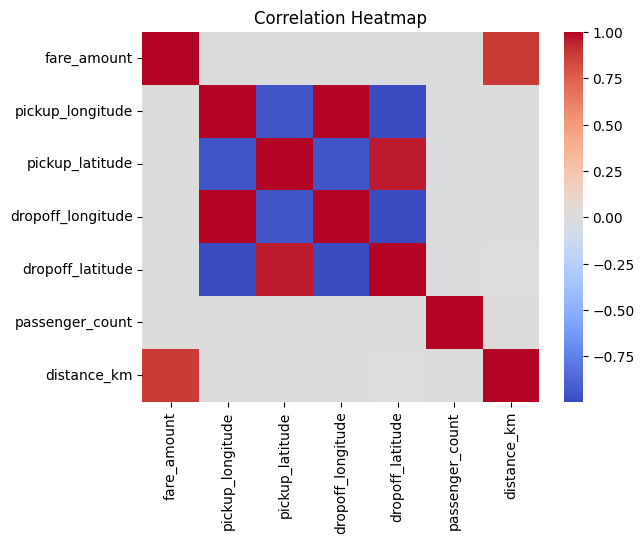

In [ ]:
numeric_df = df.select_dtypes(include=['float64','int64'])
sns.heatmap(numeric_df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# **Regression Modeling**

# Encode categorical Columns

- Machine learning models do not understand text.
- We convert time_of_day into 0/1 columns (dummy variables).
- drop_first=True avoids extra redundant columns.

In [ ]:
df = pd.get_dummies(df, columns=['time_of_day'], drop_first=True)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,distance_km,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,3,1.683323,True,False,False
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,2.457590,True,False,False
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,0,5.036377,False,False,True
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,4,1.661683,False,True,False
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,3,4.475450,True,False,False


# Split Train/Test Data + Scale Features

- We split the data:
- 80% → train
- 20% → test
- Scaling is applied only for Linear Regression because it needs normalized values.
- Decision Tree & Random Forest work fine without scaling.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df.drop(columns=['fare_amount', 'pickup_datetime'])
y = df['fare_amount']

In [ ]:
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X_train_df = X_train_df.drop(columns=['pickup_datetime'], errors='ignore')
X_test_df = X_test_df.drop(columns=['pickup_datetime'], errors='ignore')

In [ ]:
X_train_numeric = X_train_df.select_dtypes(include=[np.number])
X_test_numeric  = X_test_df.select_dtypes(include=[np.number])

X_train_numeric.head()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,distance_km
178863,-73.993225,40.757757,-73.980115,40.738360,6,2013,5,27,9,0,2.423150
177226,-73.971614,40.761034,-73.982629,40.735598,2,2009,1,6,20,1,2.976673
107943,-73.992126,40.749312,-73.980578,40.760269,1,2014,6,2,9,0,1.559025
21942,-73.959771,40.773933,-73.982812,40.742264,1,2013,8,10,9,5,4.020785
39582,-74.005415,40.722220,-74.002910,40.721953,1,2009,4,13,13,0,0.213181


In [ ]:
# Scale data for Linear Regression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)


# Train Regression Models

- Linear Regression provides a baseline simple model.
- Decision Tree captures non-linear relationships.
- Random Forest builds many trees → more accuracy, less overfitting.
- Random Forest usually becomes the best model for this dataset.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
# Decision Tree Regression
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train_numeric, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [ ]:
# Random Forest Regression
rf = RandomForestRegressor(
    n_estimators=40,   # reduced for speed
    max_depth=8,       # smaller trees = faster
    min_samples_split=10,
    min_samples_leaf=4,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_numeric, y_train)


RandomForestRegressor(max_depth=8, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=40, n_jobs=-1, random_state=42)

# Predict using all models
- We apply each trained model to unseen test data to see how well they predict fares.

In [ ]:
lr_pred = lr.predict(X_test_scaled)
dt_pred = dt.predict(X_test_numeric)
rf_pred = rf.predict(X_test_numeric)


### **Model Evaluation and Insights**

# Evaluate Model Performance
- MAE → average absolute error
- MSE → square error
- RMSE → standard deviation of prediction error
- R² score → how much variance is explained
- Random Forest usually gives the best accuracy.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def evaluate(name, true, pred):
    return {
        "Model": name,
        "MAE": mean_absolute_error(true, pred),
        "MSE": mean_squared_error(true, pred),
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "R2 Score": r2_score(true, pred)
    }

results = []
results.append(evaluate("Linear Regression", y_test, lr_pred))
results.append(evaluate("Decision Tree", y_test, dt_pred))
results.append(evaluate("Random Forest", y_test, rf_pred))

pd.DataFrame(results)


,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,2.240856,18.847229,4.341340,0.788488
1,Decision Tree,1.984119,16.188639,4.023511,0.818324
2,Random Forest,1.962499,13.558070,3.682128,0.847845


# Hyper Parameter Tunning

- We test multiple versions of Random Forest.
- The best model is selected automatically.
- We get improved accuracy after tuning.

In [ ]:
# 1. Drop datetime
df = df.drop(columns=["pickup_datetime"], errors="ignore")

# 2. Prepare X and y
X = df.drop(columns=["fare_amount"])
y = df["fare_amount"]

# 3. Split
from sklearn.model_selection import train_test_split
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Create NUMERIC-ONLY training and testing data
X_train = X_train_df.select_dtypes(include=['float64', 'int64'])
X_test = X_test_df.select_dtypes(include=['float64', 'int64'])

print("X_train is ready!", X_train.shape)
print("X_test is ready!", X_test.shape)


X_train is ready! (154530, 6)
X_test is ready! (38633, 6)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [30, 50, 70],
    "max_depth": [5, 7, 9],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 4]
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=4,
    cv=2,
    scoring="r2",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train_df, y_train)
best_rf = rf_random.best_estimator_

print("Best Parameters:", rf_random.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Parameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 9}


# Feature Importance

- This shows which features MOST affect fare prediction.
- distance_km — highest impact
- hour — peak time pricing
- weekday — weekend vs weekday
- month — seasonal changes
- This helps the business understand pricing behaviour.

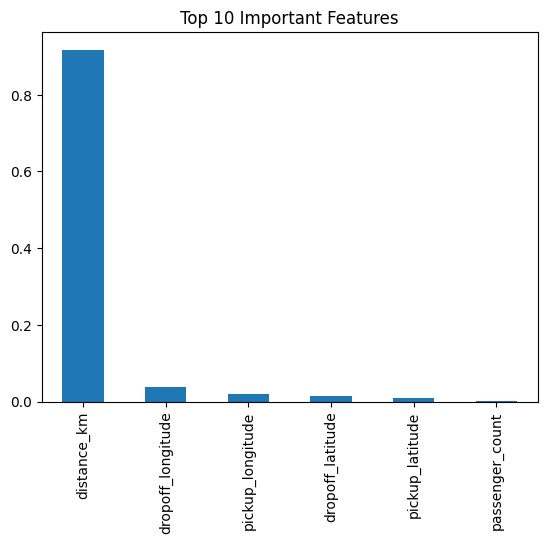

,0
distance_km,0.917725
dropoff_longitude,0.037759
pickup_longitude,0.019404
dropoff_latitude,0.014465
pickup_latitude,0.009995
passenger_count,0.000653


In [ ]:
fi = pd.Series(best_rf.feature_importances_, index=X_train.columns)

fi.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Important Features")
plt.show()

fi.sort_values(ascending=False).head(10)


# Predict on New Data

- This shows how the model predicts fare for a new ride.
- This is exactly how Uber estimates the fare before the customer books.

In [ ]:
new_data = {
    'pickup_latitude': [40.761432],
    'pickup_longitude': [-73.979815],
    'dropoff_latitude': [40.651311],
    'dropoff_longitude': [-73.870245],
    'passenger_count': [2],
    'distance_km': [8.52]   # You must calculate using haversine
}

new_df = pd.DataFrame(new_data)


In [ ]:
new_df = new_df[X_train.columns]
best_rf.predict(new_df)

array([26.43553208])